
# Handball AI: How to Detect, Track, and Identify Handball Players

## Environment setup

### Configure your API keys

To run this notebook, you need to provide your HuggingFace Token and Roboflow API key.  

- The `ROBOFLOW_API_KEY` is required to pull the fine-tuned RF-DETR player detector and the SmolVLM2 number recognizer from Roboflow Universe.  
- The `HF_TOKEN` is required to pull the pretrained SigLIP model from HuggingFace.  

Follow these steps:  

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate a new token.  
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.  
- In Colab, go to the left pane and click on `Secrets` (🔑).  
    - Store the HuggingFace Access Token under the name `HF_TOKEN`.  
    - Store the Roboflow API Key under the name `ROBOFLOW_API_KEY`.  

In [ ]:
import os

os.environ["HF_TOKEN"] = ""
os.environ["ROBOFLOW_API_KEY"] = "<REDACTED>"

### Check GPU availability

Let's make sure we have access to a GPU. Run the `nvidia-smi` command to verify. If you run into issues, go to `Runtime` -> `Change runtime type`, select `T4 GPU` or `L4 GPU`, and then click `Save`.

In [16]:
!nvidia-smi

Mon Nov 24 16:43:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GB10                    On  |   0000000F:01:00.0 Off |                  N/A |
| N/A   40C    P0             10W /  N/A  | Not Supported          |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [17]:
from pathlib import Path

HOME = Path.cwd()
print("HOME:", HOME)

HOME: /home/valentinweyer/projects/handball-computer-vision


## Install SAM2 real-time

We will use `segment-anything-2-real-time`, an open-source fork of Meta’s Segment Anything Model 2 optimized for real-time inference. After installing the repository, we will also download the required checkpoint files.


In [ ]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130

In [ ]:
import os, site, pathlib

# 1) Make sure CUDA is visible *inside this notebook process*
os.environ["CUDA_HOME"] = "/usr/local/cuda-13.0"
os.environ["PATH"] = os.environ["CUDA_HOME"] + "/bin:" + os.environ["PATH"]
os.environ["LD_LIBRARY_PATH"] = os.environ["CUDA_HOME"] + "/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")

print("CUDA_HOME:", os.environ["CUDA_HOME"])

In [ ]:
# 2) Clone repo into a fixed location (if not already there)
base = "/home/valentinweyer/projects/handball-computer-vision"
os.makedirs(base, exist_ok=True)
os.chdir(base)

if not pathlib.Path("segment-anything-2-real-time").exists():
    !git clone https://github.com/Gy920/segment-anything-2-real-time.git
else:
    print("Repo already cloned")

os.chdir("segment-anything-2-real-time")
print("CWD:", os.getcwd())

In [ ]:
# 3) Install build dependencies in this env
!pip install "numpy<2" ninja cmake setuptools wheel

In [ ]:
# 4) Build the CUDA extension in-place
!python setup.py build_ext --inplace

In [ ]:
import site, os, pathlib

repo_path = pathlib.Path("/home/valentinweyer/projects/handball-computer-vision/segment-anything-2-real-time")
site_dir = site.getsitepackages()[0]
pth_path = pathlib.Path(site_dir) / "segment_anything_2_real_time.pth"

with open(pth_path, "w") as f:
    f.write(str(repo_path) + "\n")

print("Wrote .pth file:", pth_path)
print("Points to:", repo_path)

In [ ]:
%cd /home/valentinweyer/projects/handball-computer-vision/segment-anything-2-real-time

!pip install \
  "numpy>=1.24.4,<2" \
  "tqdm>=4.66.1" \
  "hydra-core>=1.3.2" \
  "iopath>=0.1.10" \
  "pillow>=9.4.0,<12.0" \
  "torchvision>=0.18.1"

In [ ]:
!(cd checkpoints && bash download_ckpts.sh)

## Install dependencies

In [ ]:
!pip install -q gdown
!pip install supervision
!pip install -q git+https://github.com/roboflow/sports.git@feat/basketball
!pip install -q transformers num2words



### DGX Spark specific install
I ran this on DGX Spark. There the aarch64 wheels for onnxruntime-gpu are not available yet, which is why I had to manually build it. The instructions are below. Skip, if you are not on DGX Spark.

In [19]:
import os, pathlib

base = "/home/valentinweyer/projects" # give your base path here
os.makedirs(base, exist_ok=True)
os.chdir(base)

if not pathlib.Path("onnxruntime").exists():
    !git clone --recursive https://github.com/microsoft/onnxruntime.git
else:
    print("onnxruntime repo already exists")

%cd onnxruntime

onnxruntime repo already exists
/home/valentinweyer/projects/onnxruntime


Build the onnxruntime. This my takes some time.

In [ ]:
!sh build.sh \
  --config Release \
  --build_dir build/cuda13 \
  --parallel 20 \
  --nvcc_threads 20 \
  --use_cuda \
  --cuda_version 13.0 \
  --cuda_home /usr/local/cuda-13.0/ \
  --cudnn_home /usr/local/cuda-13.0/ \
  --build_wheel \
  --skip_tests \
  --cmake_generator Ninja \
  --use_binskim_compliant_compile_flags \
  --cmake_extra_defines CMAKE_CUDA_ARCHITECTURES=121 onnxruntime_BUILD_UNIT_TESTS=OFF

In [ ]:
!pip install build/cuda13/Release/dist/*.whl

In [ ]:
!pip install --no-deps inference-gpu

In [ ]:
!pip install \
  "aiohttp>=3.9.0,<=3.10.11" \
  "aiortc>=1.9.0" \
  "anthropic~=0.49.0" \
  "APScheduler>=3.10.1,<4.0.0" \
  "asyncua~=1.1.5" \
  "backoff~=2.2.0" \
  "boto3<=1.35.60" \
  "cachetools<6.0.0" \
  "click<8.2.0" \
  "cython~=3.0.0" \
  "dataclasses-json~=0.6.0" \
  "docker>=7.0.0,<8.0.0" \
  "fastapi>=0.100,<0.116" \
  "httpx~=0.28.1" \
  "inference-exp>=0.15.2" \
  "nvidia-ml-py<13.0.0" \
  "onvif-zeep-async==2.0.0" \
  "openai>=1.12.0,<2.0.0" \
  "opencv-python>=4.8.1.78,<=4.10.0.84" \
  "opencv-contrib-python>=4.8.1.78,<=4.10.0.84" \
  "paho-mqtt~=1.6.1" \
  "pandas>=2.2.3,<3.0.0" \
  "prometheus-fastapi-instrumentator<=6.0.0" \
  "py-cpuinfo~=9.0.0" \
  "pybase64~=1.0.0" \
  "pydantic>=2.8.0,<2.12.0" \
  "pydantic-settings<2.8" \
  "pydot~=2.0.0" \
  "pylogix==1.0.5" \
  "pymodbus>=3.6.9,<=3.8.3" \
  "pytest>=8.0.0,<9.0.0" \
  "qrcode~=8.0.0" \
  "redis~=5.0.0" \
  "requests-toolbelt~=1.0.0" \
  "rich>=13.0.0,<15.0.0" \
  "scikit-image>=0.19.0,<=0.25.2" \
  "shapely>=2.0.4,<2.1.0" \
  "simple-pid~=2.0.1" \
  "slack-sdk~=3.33.4" \
  "structlog>=24.1.0,<25.0.0" \
  "tldextract~=5.1.2" \
  "twilio~=9.3.7" \
  "typer>=0.9.0,<=0.16.0" \
  "zxing-cpp~=2.2.0" \
  "filelock>=3.12.0,<=3.17.0" \
  "packaging~=24.0" \
  "pillow>=11.0,<12.0" \
  "python-dotenv~=1.0.0" \
  "typing_extensions>=4.8.0,<=4.12.2"

In [ ]:
#skipped, 
# !pip install -q flash-attn --no-build-isolation

### General NVIDIA GPU installation
Use this, if you have an NVIDIA GPU

In [ ]:
!pip install -q inference-gpu

Set the ONNX Runtime execution provider to CUDA to ensure model inference runs on the GPU.

In [ ]:
import os

os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

### Source videos

As an example, we will use sample videos from Game 1 of the 2025 NBA Playoffs between the Boston Celtics and the New York Knicks. We prepared 10 sample videos from this game.

In [20]:
SOURCE_VIDEO_DIRECTORY = HOME / "source"

#!gdown -q https://drive.google.com/drive/folders/1eDJYqQ77Fytz15tKGdJCMeYSgmoQ-2-H -O {SOURCE_VIDEO_DIRECTORY} --folder

In [21]:
!ls -la {SOURCE_VIDEO_DIRECTORY}

total 14624
drwxrwxr-x 2 valentinweyer valentinweyer     4096 Nov 24 15:24 .
drwxrwxr-x 5 valentinweyer valentinweyer     4096 Nov 24 15:24 ..
-rw-rw-r-- 1 valentinweyer valentinweyer 14963330 Nov 24 15:23 FelixClaar.mp4


In [22]:

SOURCE_VIDEO_PATH = SOURCE_VIDEO_DIRECTORY / "FelixClaar.mp4"

### Team rosters

We are preparing player rosters for both teams. We load the official lists that link jersey numbers to player names. These mappings will let us replace detected numbers with real names, making the final analytics clear and readable.

In [ ]:
TEAM_ROSTERS = {
  "New York Knicks": {
    "55": "Hukporti",
    "1": "Payne",
    "0": "Wright",
    "11": "Brunson",
    "3": "Hart",
    "32": "Towns",
    "44": "Shamet",
    "25": "Bridges",
    "2": "McBride",
    "23": "Robinson",
    "8": "Anunoby",
    "4": "Dadiet",
    "5": "Achiuwa",
    "13": "Kolek"
  },
  "Boston Celtics": {
    "42": "Horford",
    "55": "Scheierman",
    "9": "White",
    "20": "Davison",
    "7": "Brown",
    "0": "Tatum",
    "27": "Walsh",
    "4": "Holiday",
    "8": "Porzingis",
    "40": "Kornet",
    "88": "Queta",
    "11": "Pritchard",
    "30": "Hauser",
    "12": "Craig",
    "26": "Tillman"
  }
}

TEAM_COLORS = {
    "New York Knicks": "#006BB6",
    "Boston Celtics": "#007A33"
}

## Import dependencies

In [23]:
from IPython.display import Video
from typing import Dict, List, Optional, Union, Iterable, Tuple
from operator import itemgetter

import cv2
import numpy as np
import torch
from tqdm import tqdm

import supervision as sv
from inference import get_model
from sports import (
    clean_paths,
    ConsecutiveValueTracker,
    TeamClassifier,
    MeasurementUnit,
    ViewTransformer
)
from sports.basketball import (
    CourtConfiguration,
    League,
    draw_court,
    draw_points_on_court,
    draw_paths_on_court
)

## Object detection

The model used in this notebook detects the following classes: `ball`, `ball-in-basket`, `number`, `player`, `player-in-possession`, `player-jump-shot`, `player-layup-dunk`, `player-shot-block`, `referee`, and `rim`. These classes enable tracking of game events, player actions, and ball location for basketball analytics.

### Load RF-DETR object detection model

In [24]:
PLAYER_DETECTION_MODEL_ID = "player-and-handball-detection-3z9xf/1"
PLAYER_DETECTION_MODEL_CONFIDENCE = 0.4
PLAYER_DETECTION_MODEL_IOU_THRESHOLD = 0.9
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID)

COLOR = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

### Single frame object detection

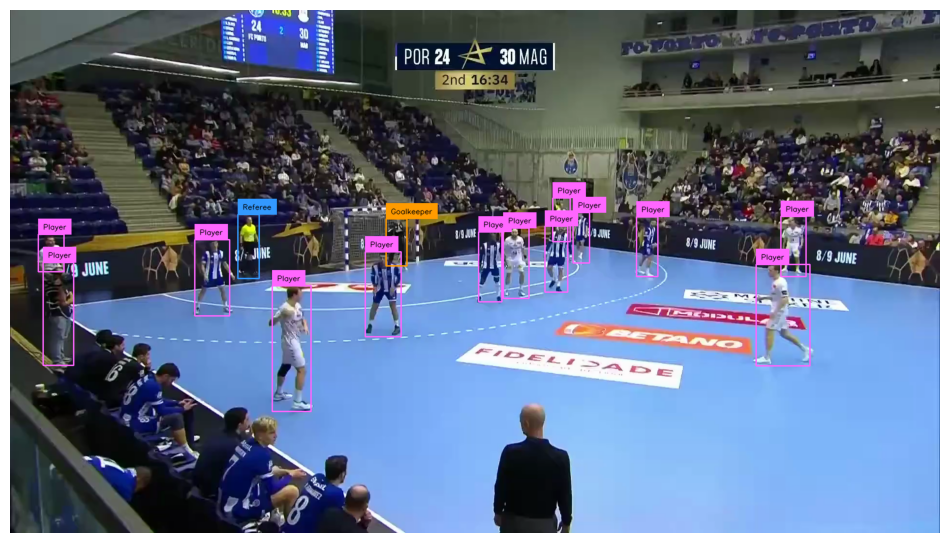

In [25]:
box_annotator = sv.BoxAnnotator(color=COLOR, thickness=2)
label_annotator = sv.LabelAnnotator(color=COLOR, text_color=sv.Color.BLACK)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections)

sv.plot_image(annotated_frame)

### Keep only "number" class

In [ ]:
NUMBER_CLASS_ID = 4

box_annotator = sv.BoxAnnotator(color=COLOR, thickness=2)
label_annotator = sv.LabelAnnotator(color=COLOR, text_color=sv.Color.BLACK)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[detections.class_id == NUMBER_CLASS_ID]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections)

sv.plot_image(annotated_frame)

### Keep only player-related classes

In [ ]:
PLAYER_CLASS_IDS = [1, 2] # player, player-in-possession, player-jump-shot, player-layup-dunk, player-shot-block

box_annotator = sv.BoxAnnotator(color=COLOR, thickness=2)
label_annotator = sv.LabelAnnotator(color=COLOR, text_color=sv.Color.BLACK)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections)

sv.plot_image(annotated_frame)

### Full video object detection

We are running RF-DETR across all frames to produce a per-frame sequence of detections. These sequences seed tracking and provide number crops over time.

In [ ]:
TARGET_VIDEO_PATH = HOME / f"{SOURCE_VIDEO_PATH.stem}-detection{SOURCE_VIDEO_PATH.suffix}"
TARGET_VIDEO_COMPRESSED_PATH = HOME / f"{TARGET_VIDEO_PATH.stem}-detection{TARGET_VIDEO_PATH.suffix}"

box_annotator = sv.BoxAnnotator(color=COLOR, thickness=2)
label_annotator = sv.LabelAnnotator(color=COLOR, text_color=sv.Color.BLACK)

def callback(frame: np.ndarray, index: int) -> np.ndarray:
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
    detections = sv.Detections.from_inference(result)

    annotated_frame = frame.copy()
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    return annotated_frame

sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback,
    show_progress=True
)

!ffmpeg -y -loglevel error -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

In [ ]:
Video(TARGET_VIDEO_COMPRESSED_PATH, embed=True, width=720)

## Player tracking

We are switching from frame-wise boxes to temporal tracks. SAM2 yields per-player masks and stable track IDs that persist through occlusions and re-entries.

### Load SAM2 tracking model

We are loading a SAM2 checkpoint and config into the camera predictor. The large variant yields the highest quality masks; swap to smaller for speed if needed.

In [ ]:
%cd $HOME/segment-anything-2-real-time

from sam2.build_sam import build_sam2_camera_predictor

SAM2_CHECKPOINT = "checkpoints/sam2.1_hiera_large.pt"
SAM2_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_camera_predictor(SAM2_CONFIG, SAM2_CHECKPOINT)

### Full video player tacking

We are prompting SAM2 with RF-DETR boxes and tracking across the clip. The callback saves masks, IDs, and visualizations for downstream use.

In [ ]:
from __future__ import annotations

class SAM2Tracker:
    def __init__(self, predictor) -> None:
        self.predictor = predictor
        self._prompted = False

    def prompt_first_frame(self, frame: np.ndarray, detections: sv.Detections) -> None:
        if len(detections) == 0:
            raise ValueError("detections must contain at least one box")

        if detections.tracker_id is None:
            detections.tracker_id = list(range(1, len(detections) + 1))

        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
            self.predictor.load_first_frame(frame)
            for xyxy, obj_id in zip(detections.xyxy, detections.tracker_id):
                bbox = np.asarray([xyxy], dtype=np.float32)
                self.predictor.add_new_prompt(
                    frame_idx=0,
                    obj_id=int(obj_id),
                    bbox=bbox,
                )

        self._prompted = True

    def propagate(self, frame: np.ndarray) -> sv.Detections:
        if not self._prompted:
            raise RuntimeError("Call prompt_first_frame before propagate")

        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
            tracker_ids, mask_logits = self.predictor.track(frame)

        tracker_ids = np.asarray(tracker_ids, dtype=np.int32)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        if masks.ndim == 2:
            masks = masks[None, ...]

        masks = np.array([
            sv.filter_segments_by_distance(mask, relative_distance=0.03, mode="edge")
            for mask in masks
        ])

        xyxy = sv.mask_to_xyxy(masks=masks)
        detections = sv.Detections(xyxy=xyxy, mask=masks, tracker_id=tracker_ids)
        return detections

    def reset(self) -> None:
        self._prompted = False

In [ ]:
TARGET_VIDEO_PATH = HOME / f"{SOURCE_VIDEO_PATH.stem}-mask{SOURCE_VIDEO_PATH.suffix}"
TARGET_VIDEO_COMPRESSED_PATH = HOME / f"{TARGET_VIDEO_PATH.stem}-compressed{TARGET_VIDEO_PATH.suffix}"

# define team annotators

mask_annotator = sv.MaskAnnotator(
    color=COLOR,
    color_lookup=sv.ColorLookup.TRACK,
    opacity=0.5)
box_annotator = sv.BoxAnnotator(
    color=COLOR,
    color_lookup=sv.ColorLookup.TRACK,
    thickness=2
)

# we use RF-DETR model to aquire future SAM2 prompt

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]
detections.tracker_id = np.arange(1, len(detections.class_id) + 1)

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
sv.plot_image(annotated_frame)

# we prompt SAM2 using RF-DETR model detections

tracker = SAM2Tracker(predictor)
tracker.prompt_first_frame(frame, detections)

# we propagate tacks across all video frames

def callback(frame: np.ndarray, index: int) -> np.ndarray:
    detections = tracker.propagate(frame)
    annotated_frame = frame.copy()
    annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    return annotated_frame

sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback,
    show_progress=True
)

!ffmpeg -y -loglevel error -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

In [ ]:
Video(TARGET_VIDEO_COMPRESSED_PATH, embed=True, width=720)

---------------

**Handball specific only until here.**
**Following code may not work properly.**


## Cluster players into teams

EWe are assigning each track to a team without labels. The pipeline uses SigLIP embeddings, UMAP to 3D, then K-means with k=2 for final team IDs.

### Collecting training set

We are sampling frames at 1 FPS, detecting players, and extracting central crops. Central regions emphasize jersey color and texture while reducing background artifacts.

In [ ]:
STRIDE = 30

crops = []

for video_path in sv.list_files_with_extensions(SOURCE_VIDEO_DIRECTORY, extensions=["mp4", "avi", "mov"]):
    frame_generator = sv.get_video_frames_generator(source_path=video_path, stride=STRIDE)

    for frame in tqdm(frame_generator):

        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD, class_agnostic_nms=True)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]

        boxes = sv.scale_boxes(xyxy=detections.xyxy, factor=0.4)
        for box in boxes:
            crops.append(sv.crop_image(frame, box))

In [ ]:
sv.plot_images_grid(
    images=crops[:100],
    grid_size=(10, 10),
    size=(10, 10)
)

### Train and test clustering model

We are computing SigLIP embeddings for crops, reducing with UMAP, and fitting K-means. A quick validation confirms separation by uniform appearance.

In [ ]:
team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

In [ ]:
teams = team_classifier.predict(crops)

team_0 = [crop for crop, team in zip(crops, teams) if team == 0]
team_1 = [crop for crop, team in zip(crops, teams) if team == 1]

sv.plot_images_grid(
    images=team_0[:50],
    grid_size=(5, 10),
    size=(10, 5)
)

sv.plot_images_grid(
    images=team_1[:50],
    grid_size=(5, 10),
    size=(10, 5)
)

### Test clustering model on single video frame

We are applying the trained clustering to one frame’s player crops. The output assigns provisional team IDs to confirm the mapping before full-video use.

In [ ]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD, class_agnostic_nms=True)[0]
detections = sv.Detections.from_inference(result)
detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]

boxes = sv.scale_boxes(xyxy=detections.xyxy, factor=0.4)
crops = [sv.crop_image(frame, box) for box in boxes]
teams = np.array(team_classifier.predict(crops))

team_0 = [crop for crop, team in zip(crops, teams) if team == 0]
team_1 = [crop for crop, team in zip(crops, teams) if team == 1]

sv.plot_images_grid(
    images=team_0[:10],
    grid_size=(1, 10),
    size=(10, 1)
)

sv.plot_images_grid(
    images=team_1[:10],
    grid_size=(1, 10),
    size=(10, 1)
)

Since we do not control which IDs the clustering algorithm assigns to the teams, after training and testing we must select one of the dictionaries below.

In [ ]:
TEAM_NAMES = {
    0: "New York Knicks",
    1: "Boston Celtics",
}

# TEAM_NAMES = {
#     0: "Boston Celtics",
#     1: "New York Knicks",
# }

### Full video team clustering

We are assigning team IDs to tracks once, then reusing them across frames via track IDs. This keeps colors and labels consistent throughout the video.

In [ ]:
TARGET_VIDEO_PATH = HOME / f"{SOURCE_VIDEO_PATH.stem}-teams{SOURCE_VIDEO_PATH.suffix}"
TARGET_VIDEO_COMPRESSED_PATH = HOME / f"{TARGET_VIDEO_PATH.stem}-compressed{TARGET_VIDEO_PATH.suffix}"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# define team annotators

team_colors = sv.ColorPalette.from_hex([
    TEAM_COLORS[TEAM_NAMES[0]],
    TEAM_COLORS[TEAM_NAMES[1]]
])

team_mask_annotator = sv.MaskAnnotator(
    color=team_colors,
    opacity=0.5,
    color_lookup=sv.ColorLookup.INDEX
)

team_box_annotator = sv.BoxAnnotator(
    color=team_colors,
    thickness=2,
    color_lookup=sv.ColorLookup.INDEX
)

# we use RF-DETR model to aquire future SAM2 prompt

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]
detections.tracker_id = np.arange(1, len(detections.class_id) + 1)

# we determine the team for each player and assign a team ID to every detection

boxes = sv.scale_boxes(xyxy=detections.xyxy, factor=0.4)
crops = [sv.crop_image(frame, box) for box in boxes]
TEAMS = np.array(team_classifier.predict(crops))

# we prompt SAM2 using RF-DETR model detections

tracker = SAM2Tracker(predictor)
tracker.prompt_first_frame(frame, detections)

# we propagate tacks across all video frames

def callback(frame: np.ndarray, index: int) -> np.ndarray:
    detections = tracker.propagate(frame)
    annotated_frame = frame.copy()
    annotated_frame = team_mask_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        custom_color_lookup=TEAMS[detections.tracker_id - 1]
    )
    annotated_frame = team_box_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        custom_color_lookup=TEAMS[detections.tracker_id - 1]
    )
    return annotated_frame

sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback,
    show_progress=True
)

!ffmpeg -y -loglevel error -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

In [ ]:
Video(TARGET_VIDEO_COMPRESSED_PATH, embed=True, width=720)

## Player numbers OCR

We are moving to jersey OCR to identify individuals within each team. Number reads pair with tracks and teams to resolve names later.

### Load number recognition model

We are loading the fine-tuned SmolVLM2 OCR model by ID. It was trained on jersey crops and outputs digit strings suitable for downstream validation.

In [ ]:
NUMBER_RECOGNITION_MODEL_ID = "basketball-jersey-numbers-ocr/3"
NUMBER_RECOGNITION_MODEL = get_model(model_id=NUMBER_RECOGNITION_MODEL_ID)
NUMBER_RECOGNITION_MODEL_PROMPT = "Read the number."

### Single frame player number detection and recognition

We are detecting number boxes, padding, and cropping. We then run SmolVLM2 on each crop and preview predictions next to the regions.

In [ ]:
box_annotator = sv.BoxAnnotator(color=COLOR, thickness=2)
label_annotator = sv.LabelAnnotator(color=COLOR, text_color=sv.Color.BLACK)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)
frame_h, frame_w, *_ = frame.shape

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[detections.class_id == NUMBER_CLASS_ID]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections)

sv.plot_image(annotated_frame)

In [ ]:
crops = [
    sv.resize_image(sv.crop_image(frame, xyxy), resolution_wh=(224, 224))
    for xyxy
    in sv.clip_boxes(sv.pad_boxes(xyxy=detections.xyxy, px=10, py=10), (frame_w, frame_h))
]
numbers = [
    NUMBER_RECOGNITION_MODEL.predict(crop, NUMBER_RECOGNITION_MODEL_PROMPT)[0]
    for crop
    in crops
]

sv.plot_images_grid(
    images=crops[:10],
    titles=numbers[:10],
    grid_size=(1, 10),
    size=(10, 1)
)

### Single frame player detection with number detection matching

We are matching numbers to players using Intersection over Smaller Area. IoS equals 1.0 implies the number lies fully inside the player mask, so we link them.

In [ ]:
def coords_above_threshold(
    matrix: np.ndarray, threshold: float, sort_desc: bool = True
) -> List[Tuple[int, int]]:
    """
    Return all (row_index, col_index) where value > threshold.
    Rows and columns may repeat.
    Optionally sort by value descending.
    """
    A = np.asarray(matrix)
    rows, cols = np.where(A > threshold)
    pairs = list(zip(rows.tolist(), cols.tolist()))
    if sort_desc:
        pairs.sort(key=lambda rc: A[rc[0], rc[1]], reverse=True)
    return pairs

In [ ]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# define team annotators

box_annotator = sv.BoxAnnotator(color=COLOR, thickness=4, color_lookup=sv.ColorLookup.TRACK)

player_mask_annotator = sv.MaskAnnotator(color=COLOR.by_idx(3), opacity=0.8, color_lookup=sv.ColorLookup.INDEX)
number_mask_annotator = sv.MaskAnnotator(color=COLOR.by_idx(0), opacity=0.8, color_lookup=sv.ColorLookup.INDEX)

# we use RF-DETR model to aquire future SAM2 prompt

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]
detections.tracker_id = np.arange(1, len(detections.class_id) + 1)

# we prompt SAM2 using RF-DETR model detections

tracker = SAM2Tracker(predictor)
tracker.prompt_first_frame(frame, detections)

# we propagate tacks across all video frames

for index, frame in tqdm(enumerate(frame_generator)):

    # we only process the first video frame

    if index > 0:
        break

    frame_h, frame_w, *_ = frame.shape

    player_detections = tracker.propagate(frame)

    # we use RF-DETR model to detect numbers

    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
    number_detections = sv.Detections.from_inference(result)
    number_detections = number_detections[number_detections.class_id == NUMBER_CLASS_ID]
    number_detections.mask = sv.xyxy_to_mask(boxes=number_detections.xyxy, resolution_wh=(frame_w, frame_h))

    # we use mask IoS to match numbers with players

    iou = sv.mask_iou_batch(
        masks_true=player_detections.mask,
        masks_detection=number_detections.mask,
        overlap_metric=sv.OverlapMetric.IOS
    )

    pairs = coords_above_threshold(iou, 0.9)
    player_idx, number_idx = zip(*pairs)

    # we visualize all the masks

    annotated_frame = frame.copy()
    annotated_frame = player_mask_annotator.annotate(
        scene=annotated_frame,
        detections=player_detections)
    annotated_frame = number_mask_annotator.annotate(
        scene=annotated_frame,
        detections=number_detections)
    sv.plot_image(annotated_frame)

    # we visualize only matched pairs

    player_detections = player_detections[np.array(player_idx)]
    number_detections = number_detections[np.array(number_idx)]
    number_detections.tracker_id = player_detections.tracker_id

    annotated_frame = frame.copy()
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame,
        detections=player_detections)
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame,
        detections=number_detections)
    sv.plot_image(annotated_frame)

### Validating recognized numbers

We are confirming numbers across time using a consecutive-agreement threshold. The validator locks a number to a track only after repeated consistent reads.

In [ ]:
TARGET_VIDEO_PATH = HOME / f"{SOURCE_VIDEO_PATH.stem}-validated-numbers{SOURCE_VIDEO_PATH.suffix}"
TARGET_VIDEO_COMPRESSED_PATH = HOME / f"{TARGET_VIDEO_PATH.stem}-compressed{TARGET_VIDEO_PATH.suffix}"

number_validator = ConsecutiveValueTracker(n_consecutive=3)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# define team annotators

mask_annotator = sv.MaskAnnotator(
    color=COLOR,
    color_lookup=sv.ColorLookup.TRACK,
    opacity=0.7)
box_annotator = sv.BoxAnnotator(
    color=COLOR,
    color_lookup=sv.ColorLookup.TRACK,
    thickness=2)
label_annotator = sv.LabelAnnotator(
    color=COLOR,
    color_lookup=sv.ColorLookup.TRACK,
    text_color=sv.Color.BLACK,
    text_scale=0.8)

# we use RF-DETR model to aquire future SAM2 prompt

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]
detections.tracker_id = np.arange(1, len(detections.class_id) + 1)

# we prompt SAM2 using RF-DETR model detections

tracker = SAM2Tracker(predictor)
tracker.prompt_first_frame(frame, detections)

# we propagate tacks across all video frames

def callback(frame: np.ndarray, index: int) -> np.ndarray:
    player_detections = tracker.propagate(frame)

    # we perform number recognition at specific frame intervals

    if index % 5 == 0:
        frame_h, frame_w, *_ = frame.shape

        # we use RF-DETR model to detect numbers

        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
        number_detections = sv.Detections.from_inference(result)
        number_detections = number_detections[number_detections.class_id == NUMBER_CLASS_ID]
        number_detections.mask = sv.xyxy_to_mask(boxes=number_detections.xyxy, resolution_wh=(frame_w, frame_h))

        # we crop out numbers detection and run recognition model

        number_crops = [
            sv.crop_image(frame, xyxy)
            for xyxy
            in sv.clip_boxes(sv.pad_boxes(xyxy=number_detections.xyxy, px=10, py=10), (frame_w, frame_h))
        ]
        numbers = [
            NUMBER_RECOGNITION_MODEL.predict(number_crop, NUMBER_RECOGNITION_MODEL_PROMPT)[0]
            for number_crop
            in number_crops
        ]

        # we use mask IoS to match numbers with players

        iou = sv.mask_iou_batch(
            masks_true=player_detections.mask,
            masks_detection=number_detections.mask,
            overlap_metric=sv.OverlapMetric.IOS
        )

        pairs = coords_above_threshold(iou, 0.9)

        if pairs:

            player_idx, number_idx = zip(*pairs)
            player_idx = [i + 1 for i in player_idx]
            number_idx = list(number_idx)

            # we update number_validator state

            numbers = [numbers[int(i)] for i in number_idx]
            number_validator.update(tracker_ids=player_idx, values=numbers)

    # we visualize boxes and masks

    annotated_frame = frame.copy()
    annotated_frame = mask_annotator.annotate(
        scene=annotated_frame,
        detections=player_detections)
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame,
        detections=player_detections)

    # we extract validated numbers

    numbers = number_validator.get_validated(tracker_ids=player_detections.tracker_id)

    # we visualize numbers

    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=player_detections,
        labels=numbers)

    return annotated_frame


sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback,
    show_progress=True
)

!ffmpeg -y -loglevel error -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

In [ ]:
Video(TARGET_VIDEO_COMPRESSED_PATH, embed=True, width=720)

## Player recognition

We are overlaying names, numbers, team colors, and masks for each tracked player. The final render shows stable identities aligned with roster data across the full clip.

In [ ]:
!gdown https://drive.google.com/drive/folders/1RBjpI5Xleb58lujeusxH0W5zYMMA4ytO -O {HOME / "fonts"} --folder

In [ ]:
frames_history = []
detections_history = []

number_validator = ConsecutiveValueTracker(n_consecutive=3)
team_validator = ConsecutiveValueTracker(n_consecutive=1)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# we use RF-DETR model to aquire future SAM2 prompt

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]
detections.tracker_id = np.arange(1, len(detections.class_id) + 1)

# we determine the team for each player and assign a team ID to every detection

boxes = sv.scale_boxes(xyxy=detections.xyxy, factor=0.4)
crops = [sv.crop_image(frame, box) for box in boxes]
TEAMS = np.array(team_classifier.predict(crops))

team_validator.update(tracker_ids=detections.tracker_id, values=TEAMS)

# we prompt SAM2 using RF-DETR model detections

tracker = SAM2Tracker(predictor)
tracker.prompt_first_frame(frame, detections)

# we propagate tacks across all video frames

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

for index, frame in tqdm(enumerate(frame_generator)):
    player_detections = tracker.propagate(frame)
    frames_history.append(frame)
    detections_history.append(player_detections)

    # we perform number recognition at specific frame intervals

    if index % 5 == 0:
        frame_h, frame_w, *_ = frame.shape

        # we use RF-DETR model to detect numbers

        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
        number_detections = sv.Detections.from_inference(result)
        number_detections = number_detections[number_detections.class_id == NUMBER_CLASS_ID]
        number_detections.mask = sv.xyxy_to_mask(boxes=number_detections.xyxy, resolution_wh=(frame_w, frame_h))

        # we crop out numbers detection and run recognition model

        number_crops = [
            sv.crop_image(frame, xyxy)
            for xyxy
            in sv.clip_boxes(sv.pad_boxes(xyxy=number_detections.xyxy, px=10, py=10), (frame_w, frame_h))
        ]
        numbers = [
            NUMBER_RECOGNITION_MODEL.predict(number_crop, NUMBER_RECOGNITION_MODEL_PROMPT)[0]
            for number_crop
            in number_crops
        ]

        # we use mask IoS to match numbers with players

        iou = sv.mask_iou_batch(
            masks_true=player_detections.mask,
            masks_detection=number_detections.mask,
            overlap_metric=sv.OverlapMetric.IOS
        )

        pairs = coords_above_threshold(iou, 0.9)

        if pairs:

            player_idx, number_idx = zip(*pairs)
            player_idx = [i + 1 for i in player_idx]
            number_idx = list(number_idx)

            # we update number_validator state

            numbers = [numbers[int(i)] for i in number_idx]
            number_validator.update(tracker_ids=player_idx, values=numbers)

In [ ]:
TARGET_VIDEO_PATH = HOME / f"{SOURCE_VIDEO_PATH.stem}-result{SOURCE_VIDEO_PATH.suffix}"
TARGET_VIDEO_COMPRESSED_PATH = HOME / f"{TARGET_VIDEO_PATH.stem}-compressed{TARGET_VIDEO_PATH.suffix}"

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

team_colors = sv.ColorPalette.from_hex([
    TEAM_COLORS[TEAM_NAMES[0]],
    TEAM_COLORS[TEAM_NAMES[1]]
])

team_mask_annotator = sv.MaskAnnotator(
    color=team_colors,
    opacity=0.5,
    color_lookup=sv.ColorLookup.INDEX)
team_label_annotator = sv.RichLabelAnnotator(
    font_path=f"{HOME}/fonts/Staatliches-Regular.ttf",
    font_size=40,
    color=team_colors,
    text_color=sv.Color.WHITE,
    text_position=sv.Position.BOTTOM_CENTER,
    text_offset=(0, 10),
    color_lookup=sv.ColorLookup.INDEX)

with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame, detections in tqdm(zip(frames_history, detections_history)):
        detections = detections[detections.area > 100]

        teams = team_validator.get_validated(tracker_ids=detections.tracker_id)
        teams = np.array(teams).astype(int)
        numbers = number_validator.get_validated(tracker_ids=detections.tracker_id)
        numbers = np.array(numbers)

        labels = [
            f"#{number} {TEAM_ROSTERS[TEAM_NAMES[team]].get(number)}"
            for number, team
            in zip(numbers, teams)
        ]

        annotated_frame = frame.copy()
        annotated_frame = team_mask_annotator.annotate(
            scene=annotated_frame,
            detections=detections,
            custom_color_lookup=teams)
        annotated_frame = team_label_annotator.annotate(
            scene=annotated_frame,
            detections=detections,
            labels=labels,
            custom_color_lookup=teams)

        sink.write_frame(annotated_frame)

!ffmpeg -y -loglevel error -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

In [ ]:
Video(TARGET_VIDEO_COMPRESSED_PATH, embed=True, width=720)

## Court keypoints detection

### Load keypoint detection model

In [ ]:
KEYPOINT_DETECTION_MODEL_ID = "basketball-court-detection-2/14"
KEYPOINT_DETECTION_MODEL_CONFIDENCE = 0.3
KEYPOINT_DETECTION_MODEL_ANCHOR_CONFIDENCE = 0.5
KEYPOINT_DETECTION_MODEL = get_model(model_id=KEYPOINT_DETECTION_MODEL_ID)
KEYPOINT_COLOR = sv.Color.from_hex('#FF1493')

### Single frame keypoint detection

In [ ]:
vertex_annotator = sv.VertexAnnotator(color=KEYPOINT_COLOR, radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = KEYPOINT_DETECTION_MODEL.infer(frame, confidence=KEYPOINT_DETECTION_MODEL_CONFIDENCE)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

### Detecting keypoints with high confidence

In [ ]:
vertex_annotator = sv.VertexAnnotator(color=KEYPOINT_COLOR, radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = KEYPOINT_DETECTION_MODEL.infer(frame, confidence=KEYPOINT_DETECTION_MODEL_CONFIDENCE)[0]
key_points = sv.KeyPoints.from_inference(result)
key_points = key_points[:, key_points.confidence[0] > KEYPOINT_DETECTION_MODEL_ANCHOR_CONFIDENCE]

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

## Map player positions to court coordinates

## Single frame player position mapping

In [ ]:
config = CourtConfiguration(league=League.NBA, measurement_unit=MeasurementUnit.FEET)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# define team annotators

team_colors = sv.ColorPalette.from_hex([
    TEAM_COLORS[TEAM_NAMES[0]],
    TEAM_COLORS[TEAM_NAMES[1]]
])

team_box_annotator = sv.BoxAnnotator(
    color=team_colors,
    thickness=2,
    color_lookup=sv.ColorLookup.INDEX
)

# we use RF-DETR model to aquire future SAM2 prompt

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]
detections.tracker_id = np.arange(1, len(detections.class_id) + 1)

# we determine the team for each player and assign a team ID to every detection

boxes = sv.scale_boxes(xyxy=detections.xyxy, factor=0.4)
crops = [sv.crop_image(frame, box) for box in boxes]
TEAMS = np.array(team_classifier.predict(crops))

annotated_frame = frame.copy()
annotated_frame = team_box_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    custom_color_lookup=TEAMS[detections.tracker_id - 1]
)
sv.plot_image(annotated_frame)

# we use a keypoint model to detect court landmarks

result = KEYPOINT_DETECTION_MODEL.infer(frame, confidence=KEYPOINT_DETECTION_MODEL_CONFIDENCE)[0]
key_points = sv.KeyPoints.from_inference(result)
landmarks_mask = key_points.confidence[0] > KEYPOINT_DETECTION_MODEL_ANCHOR_CONFIDENCE

if np.count_nonzero(landmarks_mask) >= 4:

    # we calculate homography matrix

    court_landmarks = np.array(config.vertices)[landmarks_mask]
    frame_landmarks = key_points[:, landmarks_mask].xy[0]

    frame_to_court_transformer = ViewTransformer(
        source=frame_landmarks,
        target=court_landmarks,
    )

    frame_xy = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

    if len(frame_xy) > 0:

        # we transform points

        court_xy = frame_to_court_transformer.transform_points(points=frame_xy)

        # we visualize the results

        court = draw_court(config=config)
        court = draw_points_on_court(
            config=config,
            xy=court_xy[TEAMS == 0],
            fill_color=sv.Color.from_hex(TEAM_COLORS[TEAM_NAMES[0]]),
            court=court
        )
        court = draw_points_on_court(
            config=config,
            xy=court_xy[TEAMS == 1],
            fill_color=sv.Color.from_hex(TEAM_COLORS[TEAM_NAMES[1]]),
            court=court
        )

        sv.plot_image(court)

### Full video player position mapping

In [ ]:
video_xy = []

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# we use RF-DETR model to aquire future SAM2 prompt

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=PLAYER_DETECTION_MODEL_CONFIDENCE, iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]
detections.tracker_id = np.arange(1, len(detections.class_id) + 1)

# we determine the team for each player and assign a team ID to every detection

boxes = sv.scale_boxes(xyxy=detections.xyxy, factor=0.4)
crops = [sv.crop_image(frame, box) for box in boxes]
TEAMS = np.array(team_classifier.predict(crops))

# we prompt SAM2 using RF-DETR model detections

tracker = SAM2Tracker(predictor)
tracker.prompt_first_frame(frame, detections)

# we propagate tacks across all video frames

for frame_idx, frame in tqdm(enumerate(frame_generator)):
    detections = tracker.propagate(frame)

    # we use a keypoint model to detect court landmarks

    result = KEYPOINT_DETECTION_MODEL.infer(frame, confidence=KEYPOINT_DETECTION_MODEL_CONFIDENCE)[0]
    key_points = sv.KeyPoints.from_inference(result)
    landmarks_mask = key_points.confidence[0] > KEYPOINT_DETECTION_MODEL_ANCHOR_CONFIDENCE

    if np.count_nonzero(landmarks_mask) >= 4:

        # we calculate homography matrix

        court_landmarks = np.array(config.vertices)[landmarks_mask]
        frame_landmarks = key_points[:, landmarks_mask].xy[0]

        frame_to_court_transformer = ViewTransformer(
            source=frame_landmarks,
            target=court_landmarks,
        )

        frame_xy = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
        court_xy = frame_to_court_transformer.transform_points(points=frame_xy)
        video_xy.append(court_xy)

video_xy = np.array(video_xy)

In [ ]:
TARGET_VIDEO_PATH = HOME / f"{SOURCE_VIDEO_PATH.stem}-map{SOURCE_VIDEO_PATH.suffix}"
TARGET_VIDEO_COMPRESSED_PATH = HOME / f"{TARGET_VIDEO_PATH.stem}-compressed{TARGET_VIDEO_PATH.suffix}"

config = CourtConfiguration(league=League.NBA, measurement_unit=MeasurementUnit.FEET)
court = draw_court(config=config)
court_h, court_w, _ = court.shape

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info.width = court_w
video_info.height = court_h

with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame_xy in tqdm(video_xy):
        court = draw_court(config=config)
        court = draw_points_on_court(
            config=config,
            xy=frame_xy[TEAMS == 0],
            fill_color=sv.Color.from_hex(TEAM_COLORS[TEAM_NAMES[0]]),
            court=court
        )
        court = draw_points_on_court(
            config=config,
            xy=frame_xy[TEAMS == 1],
            fill_color=sv.Color.from_hex(TEAM_COLORS[TEAM_NAMES[1]]),
            court=court
        )

        sink.write_frame(court)

!ffmpeg -y -loglevel error -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

In [ ]:
Video(TARGET_VIDEO_COMPRESSED_PATH, embed=True, width=720)

### Clean player movement paths

We are detecting sudden jumps in position using robust speed analysis. We are removing short abnormal runs and nearby frames to eliminate teleport-like artifacts. We are filling missing segments with linear interpolation to ensure continuous motion. We are smoothing all paths with a Savitzky–Golay filter to achieve stable and natural movement.

In [ ]:
court = draw_paths_on_court(
    config=config,
    paths=[video_xy[:, 0, :]],
)

sv.plot_image(court)

In [ ]:
cleaned_xy, edited_mask = clean_paths(
    video_xy,
    jump_sigma=3.5,
    min_jump_dist=0.6,
    max_jump_run=18,
    pad_around_runs=2,
    smooth_window=9,
    smooth_poly=2,
)

In [ ]:
def split_true_runs(mask: np.ndarray, coords: np.ndarray) -> list[np.ndarray]:
    mask = mask.squeeze()
    idx = np.flatnonzero(mask)
    if idx.size == 0:
        return []
    splits = np.where(np.diff(idx) > 1)[0] + 1
    groups = np.split(idx, splits)
    return [coords[g, 0, :] for g in groups]


court = draw_paths_on_court(
    config=config,
    paths=[video_xy[:, 0, :]],
    color=sv.Color.GREEN,
)

court = draw_paths_on_court(
    config=config,
    paths=split_true_runs(edited_mask[:, 0], video_xy),
    color=sv.Color.RED,
    court=court
)

sv.plot_image(court)

In [ ]:
test = draw_paths_on_court(
    config=config,
    paths=[cleaned_xy[:, 0, :]],
)

sv.plot_image(test)

In [ ]:
TARGET_VIDEO_PATH = HOME / f"{SOURCE_VIDEO_PATH.stem}-map{SOURCE_VIDEO_PATH.suffix}"
TARGET_VIDEO_COMPRESSED_PATH = HOME / f"{TARGET_VIDEO_PATH.stem}-compressed{TARGET_VIDEO_PATH.suffix}"

config = CourtConfiguration(league=League.NBA, measurement_unit=MeasurementUnit.FEET)
court = draw_court(config=config)
court_h, court_w, _ = court.shape

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info.width = court_w
video_info.height = court_h

with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame_xy in tqdm(cleaned_xy):
        court = draw_court(config=config)
        court = draw_points_on_court(
            config=config,
            xy=frame_xy[TEAMS == 0],
            fill_color=sv.Color.from_hex(TEAM_COLORS[TEAM_NAMES[0]]),
            court=court
        )
        court = draw_points_on_court(
            config=config,
            xy=frame_xy[TEAMS == 1],
            fill_color=sv.Color.from_hex(TEAM_COLORS[TEAM_NAMES[1]]),
            court=court
        )

        sink.write_frame(court)

!ffmpeg -y -loglevel error -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

In [ ]:
Video(TARGET_VIDEO_COMPRESSED_PATH, embed=True, width=720)

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>